In [37]:
# All the used libraries
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib

In [49]:
# Functions 
def plot_ROC_curve(fpr,tpr,auc):
  plt.plot(fpr,tpr,label="AUC="+str(auc))
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.legend(loc=4)
  plt.show()

def plotConfusionMatrix(prediction,y):
  conf = confusion_matrix(y, prediction)
  sns.heatmap(conf, annot=True)
  plt.show()

def train_model(parameters):
  print(parameters)
  pipe = Pipeline([('vect', CountVectorizer(stop_words=parameters["stopwords"], ngram_range = parameters["ngram_range"])),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegressionCV(solver=parameters["solver"]))])
                
  model = pipe.fit(x_train, y_train)
  prediction = model.predict(x_val)
  accuracy = round(accuracy_score(y_val, prediction)*100,2)
  print("accuracy: {}%".format(accuracy))
  fpr, tpr, _ = metrics.roc_curve(y_val,  prediction)
  auc = metrics.roc_auc_score(y_val, prediction)
  plot_ROC_curve(fpr,tpr,auc)
  plotConfusionMatrix(prediction=prediction,y=y_val)
  return accuracy

def find_best_model():

  best_acc = 0.0
  best_params = {}

  ranges = [(1,1),(1,2),(2,2)]
  stops = [None, 'english']

  for range,stopword in itertools.product(ranges,stops):
    params = {
        "ngram_range": range,
        "solver": 'liblinear',
        "stopwords": stopword
    }
    acc = train_model(parameters=params)
    if acc > best_acc:
      best_acc = acc
      best_params = params

  print("Best accuracy: {}% for {}% ".format(best_acc,best_params)) 
  return best_params
  
def stemSentence(sentence):
  porter = PorterStemmer()
  token_words=word_tokenize(sentence)
  stem_sentence=[]
  for word in token_words:
    stem_sentence.append(porter.stem(word))
    stem_sentence.append(" ")
  return "".join(stem_sentence)      

In [39]:
# Loading Datasets

# Fake_News_Train

news_train_url = 'https://raw.githubusercontent.com/mohannashahrad/Comp551_MiniProject2/main/fake_news/fake_news_train.csv'
news_train_df = pd.read_csv(news_train_url)
display(news_train_df)

# Fake_News_Val

news_val_url = 'https://raw.githubusercontent.com/mohannashahrad/Comp551_MiniProject2/main/fake_news/fake_news_val.csv'
news_val_df = pd.read_csv(news_val_url)
display(news_val_df)

# Fake_News_Test

news_test_url = 'https://raw.githubusercontent.com/mohannashahrad/Comp551_MiniProject2/main/fake_news/fake_news_test.csv'
news_test_df = pd.read_csv(news_test_url)
display(news_test_df)

,text,label
0,Indian fruit is so important to so many people...,0
1,"FORT WORTH, Texas — Urú Inc. will hold a confe...",0
2,"With three of the four new carriers, the Niger...",0
3,Let's start with the classic annual dividend r...,0
4,Following are some of the major events to have...,1
...,...,...
19995,"Warning: small, petty spoilers for the Game of...",1
19996,Shilpa Shetty will soon make her Bollywood deb...,0
19997,Add a digital black hole image to the Allstate...,0
19998,Share\nThe name W. L. Gore & Associates might ...,1


,text,label
0,When don't you have something appropriate to w...,0
1,Share this article with Google Plus\nA brief g...,0
2,NEW YORK — Yankees beat reporter Brendan Kuty ...,1
3,The Goonies has always posed challenges for fi...,0
4,"Parisians sang, lit candles and prayed to pay ...",1
...,...,...
1995,"KABUL - In past several weeks, hectic negotiat...",1
1996,1) Where is Wan-Bissaka in the young player sh...,1
1997,It may seem counterintuitive that Calgary shou...,0
1998,The CEOs of America's biggest banks were summo...,1


,text,label
0,Is it possible the President’s pressure campai...,0
1,Pennsylvania is the place to go for farmers ma...,1
2,While he is frantically putting together a pro...,0
3,"The one-man industry, Yasir Akhtar, is all set...",1
4,"All Parties Sanctions Group, Business Leaders,...",0
...,...,...
2995,Chennai: The proposed merger of Dena Bank and ...,0
2996,Netflix plans to buy a portion of Egyptian cin...,0
2997,About three months ago we had reported that Ta...,1
2998,The fight against HIV/AIDS and tuberculosis sh...,0


In [40]:
# Data Cleaning

news_train_df.dropna(inplace=True)
news_train_df.drop_duplicates(inplace=True)
news_val_df.dropna(inplace=True)
news_val_df.drop_duplicates(inplace=True)

In [41]:
# Data Preprocessing

# Part 1: Handling Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

In [42]:
# Function for expanding the extractions in news'values


def expandContractions(text,contractions_dict=contractions_dict):
    regex=re.compile('(%s)' % '|'.join(contractions_dict.keys()))
    def replace(match):
        return contractions_dict[match.group(0)]
    return regex.sub(replace, text)

news_train_df['text'] = news_train_df['text'].apply(lambda x:expandContractions(x))
news_val_df['text'] = news_val_df['text'].apply(lambda x:expandContractions(x))
news_test_df['text'] = news_test_df['text'].apply(lambda x:expandContractions(x))   

# Pre-Processing Part 2 : Lower Case 
news_train_df['text'] = news_train_df['text'].apply(lambda x:x.lower())
news_val_df['text'] = news_val_df['text'].apply(lambda x:x.lower())
news_test_df['text'] = news_test_df['text'].apply(lambda x:x.lower())

# Pre-Processing Part 3 : Removing Punctuatoins
news_train_df['text'] = news_train_df['text'].apply(lambda x:re.sub(r'[^\w\s]','', x))
news_val_df['text'] = news_val_df['text'].apply(lambda x:re.sub(r'[^\w\s]','', x))
news_test_df['text'] = news_test_df['text'].apply(lambda x:re.sub(r'[^\w\s]','', x))

# Pre-Processing Part 4 : Removing Extra Spaces
news_train_df['text'] = news_train_df['text'].apply(lambda x:re.sub(' +',' ',x))
news_val_df['text'] = news_val_df['text'].apply(lambda x:re.sub(' +',' ',x))
news_test_df['text'] = news_test_df['text'].apply(lambda x:re.sub(' +',' ',x))


# Pre-Processing Part 5 : Stemming
#nltk.download('punkt')
#news_train_df['text'] = news_train_df['text'].apply(lambda x:stemSentence(x))
#news_val_df['text'] = news_val_df['text'].apply(lambda x:stemSentence(x)) 

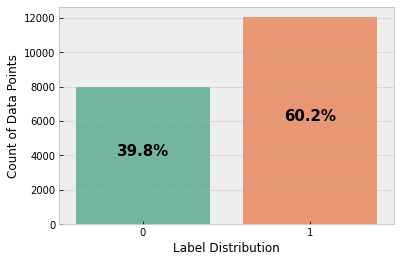

In [43]:
# Analyzing some features in the riginal data (Count, Count of characters, Count of words)

plt.style.use('bmh')

axis=sns.countplot(x="label",palette='Set2',data=news_train_df)
for patch in axis.patches:
    axis.text(x = patch.get_x() + patch.get_width()/2, y = patch.get_height()/2,
    s = f"{np.round(patch.get_height()/len(news_train_df)*100, 1)}%",
    ha = 'center', size = 15, weight = 'bold',color = 'black')
plt.xlabel("Label Distribution", size=12)
plt.ylabel('Count of Data Points', size=12)
plt.show()

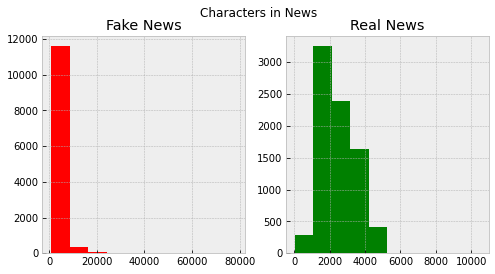

In [44]:
fig, (ax1,ax2)=plt.subplots(1,2, figsize=(8,4))

news_len = news_train_df[news_train_df['label']==1]['text'].str.len()
ax1.hist(news_len,color='red')
ax1.set_title("Fake News")

news_len = news_train_df[news_train_df['label']==0]['text'].str.len()
ax2.hist(news_len,color='green')
ax2.set_title("Real News")

fig.suptitle("Characters in News")
plt.show()

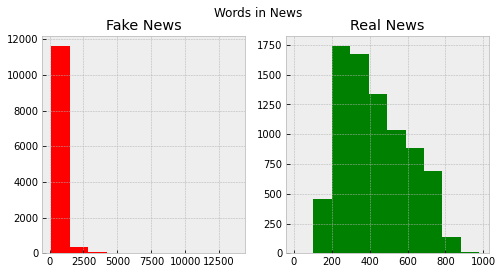

In [45]:
fig, (ax1,ax2)=plt.subplots(1,2, figsize=(8,4))

news_len = news_train_df[news_train_df['label']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(news_len,color='red')
ax1.set_title("Fake News")

news_len = news_train_df[news_train_df['label']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(news_len,color='green')
ax2.set_title("Real News")

fig.suptitle("Words in News")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


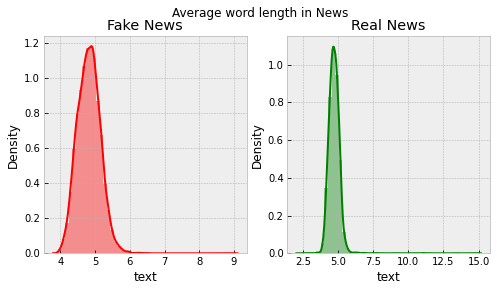

In [46]:
# Average word_length in fake/real news
fig, (ax1,ax2)=plt.subplots(1,2, figsize=(8,4))

word_len = news_train_df[news_train_df['label']==1]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word_len.map(lambda x: np.mean(x)),ax=ax1,color='red')
ax1.set_title("Fake News")

word_len = news_train_df[news_train_df['label']==0]['text'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word_len.map(lambda x: np.mean(x)),ax=ax2,color='green')
ax2.set_title("Real News")

fig.suptitle("Average word length in News")
plt.show()

In [47]:
# Defining X_train and Y_train based on the news_train_df
y_train = news_train_df['label']
x_train = news_train_df['text']
x_test = news_test_df['text']
y_test = news_test_df['label']
x_val = news_val_df['text']
y_val = news_val_df['label']

{'ngram_range': (1, 1), 'solver': 'liblinear', 'stopwords': None}
accuracy: 75.65%


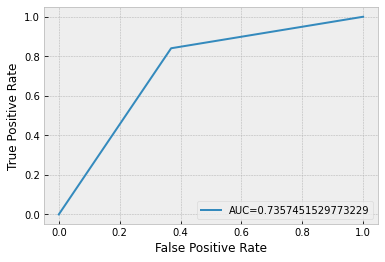

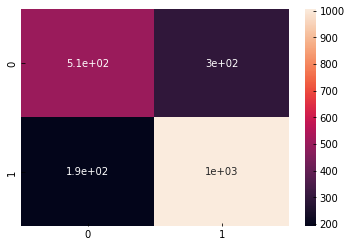

{'ngram_range': (1, 1), 'solver': 'liblinear', 'stopwords': 'english'}
accuracy: 72.2%


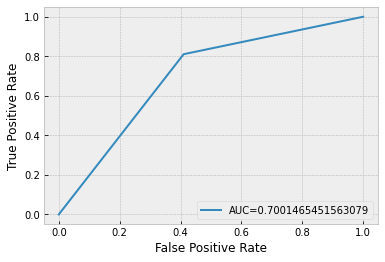

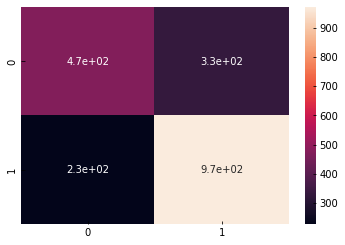

{'ngram_range': (1, 2), 'solver': 'liblinear', 'stopwords': None}
accuracy: 77.3%


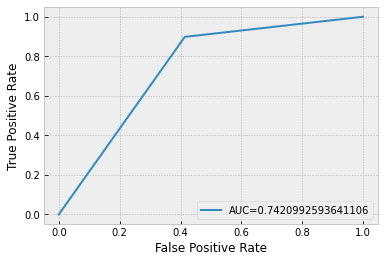

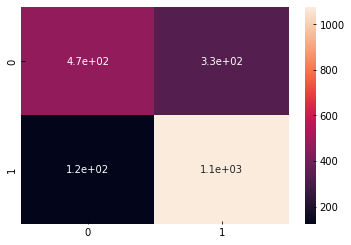

{'ngram_range': (1, 2), 'solver': 'liblinear', 'stopwords': 'english'}
accuracy: 73.75%


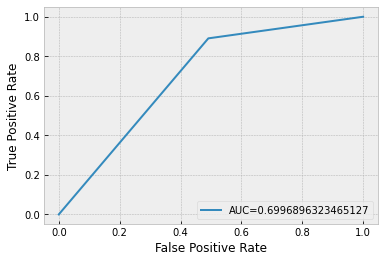

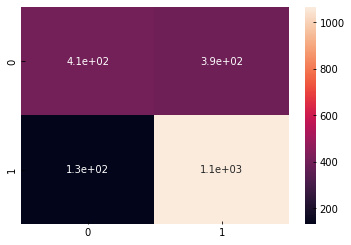

{'ngram_range': (2, 2), 'solver': 'liblinear', 'stopwords': None}
accuracy: 74.2%


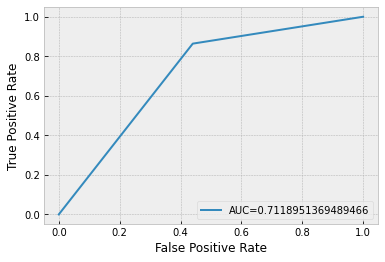

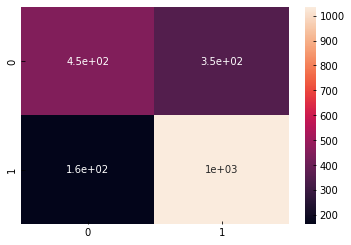

{'ngram_range': (2, 2), 'solver': 'liblinear', 'stopwords': 'english'}
accuracy: 71.2%


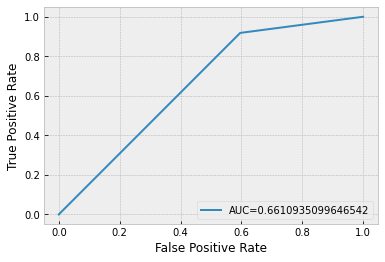

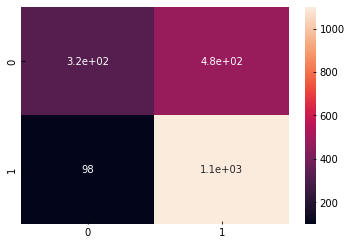

Best accuracy: 77.3% for {'ngram_range': (1, 2), 'solver': 'liblinear', 'stopwords': None}% 


In [50]:
# Finding the best model on validation set 
best_model_params = find_best_model()

accuracy: 77.5%


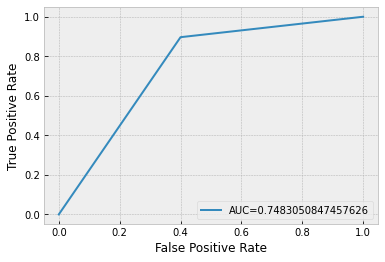

3000


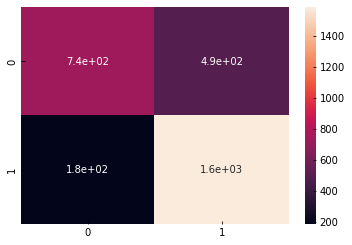

In [51]:
pipe = Pipeline([('vect', CountVectorizer(stop_words=None, ngram_range = best_model_params["ngram_range"])),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegressionCV(solver=best_model_params["solver"]))])
                
model = pipe.fit(x_train, y_train)
prediction = model.predict(x_test)
accuracy = round(accuracy_score(y_test, prediction)*100,2)
print("accuracy: {}%".format(accuracy))
fpr, tpr, _ = metrics.roc_curve(y_test,  prediction)
auc = metrics.roc_auc_score(y_test, prediction)
plot_ROC_curve(fpr,tpr,auc)
print(len(prediction))
plotConfusionMatrix(prediction=prediction,y=y_test)